In [1]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('dark')
import numpy as np
import math
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,10)

/home/jupyter/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/jupyter/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


# Canada Case and Death Data by Age group and Gender

The figures below show data from [StatsCan's Detailed Confirmed Cases](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310076601) dataset via Jens von Bergmann's [CanCovidData R Package](https://github.com/mountainMath/CanCovidData). The total numbers of cases are much less (currently about 50%) of the more widely reported numbers, but they include much more detail including age and gender information.

First, use rpy2 to call the [CanCovidData/get_cansim_case_data](https://github.com/mountainMath/CanCovidData/blob/master/R/canada_covid_data_import.R#L303) as a pandas DataFrame.

In [2]:
CanCovidData = importr("CanCovidData")
cansim_cases_r = CanCovidData.get_cansim_case_data();

with localconverter(ro.default_converter + pandas2ri.converter):
    CanSimDF = ro.conversion.rpy2py(cansim_cases_r)

R[write to console]: Accessing CANSIM NDM product 13-10-0766 from Statistics Canada

R[write to console]: Parsing data

R[write to console]: Folding in metadata



### Cases by Age and Gender

Group by gender, then do value counts for each of the age group categories.

Text(0.5, 1.0, 'Stats Canada Reported Cases by Gender and Age Group')

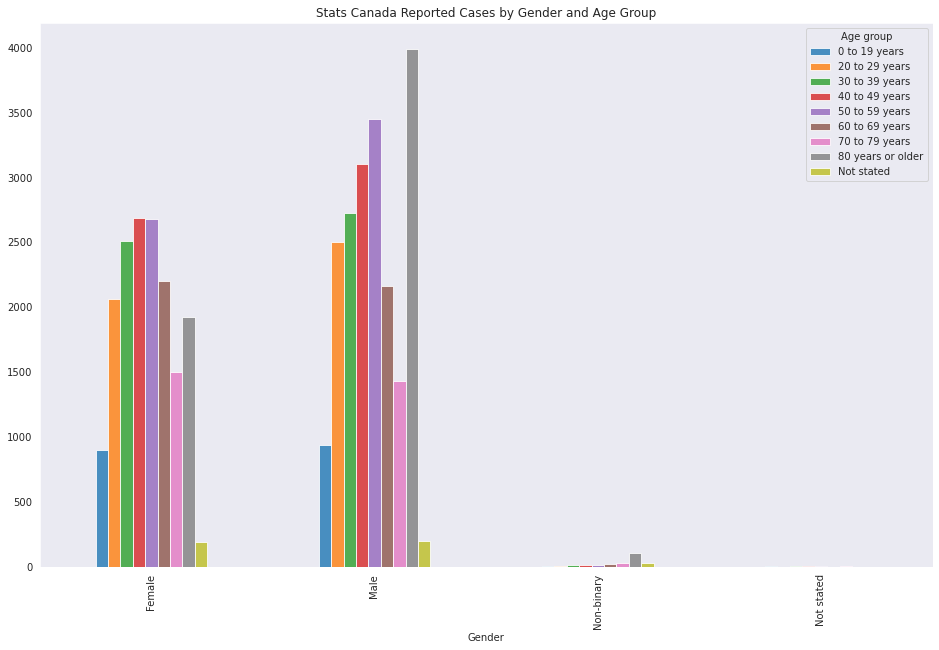

In [3]:
caseDF = (CanSimDF.groupby('Gender', observed=True)['Age group'] 
          .value_counts()
          .unstack()
)

caseDF.index = caseDF.index.astype(str).sort_values()

ax = caseDF.plot(kind='bar', alpha=0.8)
ax.set_title('Stats Canada Reported Cases by Gender and Age Group')

### Death by Age and Gender

As above, but for those cases which in which the patient has died.

Text(0.5, 1.0, 'Stats Canada Reported Deaths by Gender and Age Group')

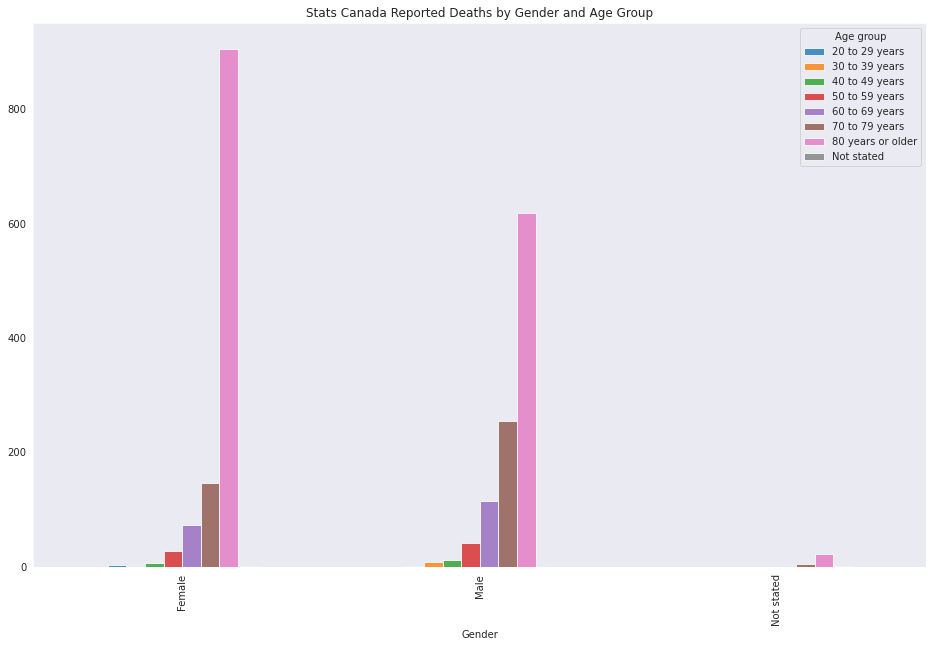

In [4]:
deathDF = (CanSimDF[CanSimDF['Death'] == 'Yes'].groupby('Gender', observed=True)['Age group'] 
          .value_counts()
          .unstack()
)

deathDF.index = deathDF.index.astype(str).sort_values()

ax = deathDF.plot(kind='bar', alpha=0.8)
ax.set_title('Stats Canada Reported Deaths by Gender and Age Group')

## Population effects?

Women tend to live longer than men on average so what if we try to account for the gender distribution? Do we still see an excess of female cases?

In [5]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

In [6]:
# You should check if this name or location is stable or if it
# changes with new data releases
resp = urlopen("https://www150.statcan.gc.ca/n1/en/tbl/csv/17100005-eng.zip")
zipfile = ZipFile(BytesIO(resp.read()))

popDF = pd.read_csv(zipfile.open(zipfile.filelist[0]))


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
year2019  = popDF['REF_DATE'] == 2019
countryCA = popDF['GEO'] == 'Canada'

popDF = popDF[year2019 & countryCA]

In [8]:
# Recode into the groups used in the COVID19 data, 10 year bins
popGroups = {}

# Group together 0-4, 5-9, 10-14, 14-20
young_groups =  [f"{age_group} to {age_group + 4} years" for age_group in range(0, 20, 5)]
young_groups_c = [popDF['Age group'] == young_group for young_group in young_groups]
popGroups['0 to 19 years'] = pd.concat([popDF[group] for group in young_groups_c]).groupby('Sex').sum()

for age_group in range(20, 79, 10):
    low_age = f"{age_group} to {age_group + 4} years"
    hi_age  = f"{age_group + 5} to {age_group + 9} years"
    low = popDF['Age group'] == low_age
    hi  = popDF['Age group'] == hi_age
    popGroups[f"{age_group} to {age_group + 9} years"] = popDF[low | hi].groupby('Sex').sum()
    

# Group together 80-84, 85-89, 90-94, 94-99, 100+    
old_groups =  [f"{age_group} to {age_group + 4} years" 
               for age_group in range(80, 99, 5)] + ["100 years and over"]

old_groups_c = [popDF['Age group'] == old_group for old_group in old_groups]
popGroups['80 years or older'] = pd.concat([popDF[group] for group in old_groups_c]).groupby('Sex').sum()

Text(0, 0.5, 'Population segment size')

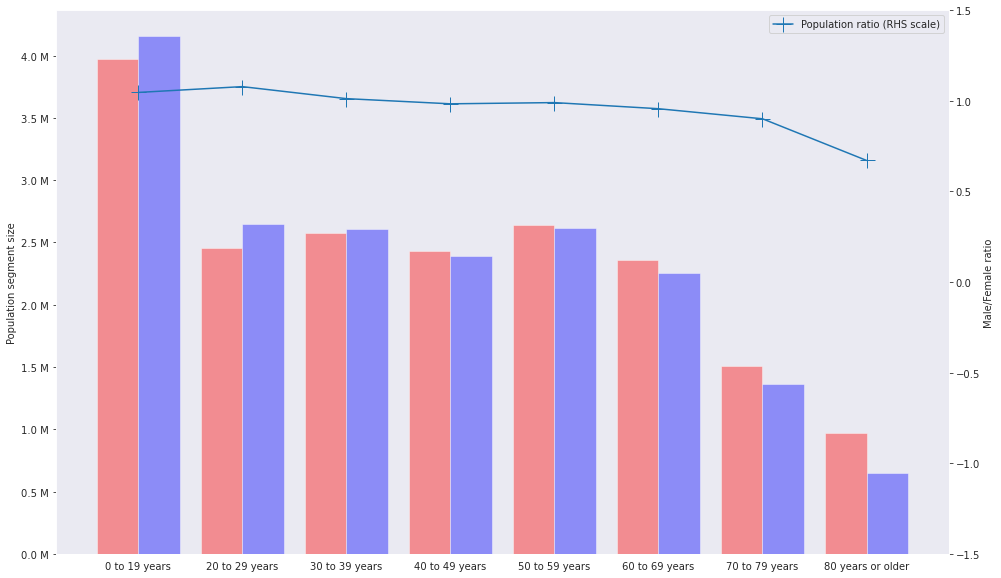

In [9]:
popDF2 = pd.concat(popGroups)['VALUE'].unstack().transpose().drop('Both sexes')
popDF2T = popDF2.transpose()


sns.set_style("dark")
fig, ax = plt.subplots()
bar_width=0.4

popDF2T = popDF2.transpose()
xtics = np.arange(len(popDF2T.index))
ax.bar(xtics, popDF2.loc['Females'], width=bar_width, alpha=0.4, color='red')
ax.bar(xtics + bar_width, popDF2.loc['Males'], width=bar_width, alpha=0.4, color='blue')


ax2 = ax.twinx()
ax2.plot(xtics + bar_width / 2, popDF2.loc['Males'] / popDF2.loc['Females'], marker='+', markersize=15)


ax.set_xticks(xtics + bar_width / 2)
ax.set_xticklabels(popDF2T.index)

ax2.set_ylabel('Male/Female ratio')
ax2.set_ylim([-1.5,1.5])
ax2.legend(["Population ratio (RHS scale)"])

ylabels = [f"{x/1e6:,.1f} M" for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.set_ylabel('Population segment size')

In [10]:
normCaseDF = caseDF.drop('Not stated', axis=1).drop(['Non-binary', 'Not stated'])
normCaseDF

Age group,0 to 19 years,20 to 29 years,30 to 39 years,40 to 49 years,50 to 59 years,60 to 69 years,70 to 79 years,80 years or older
Gender,,,,,,,,
Female,896.0,2066.0,2508.0,2688.0,2684.0,2199.0,1497.0,1928.0
Male,936.0,2500.0,2725.0,3105.0,3449.0,2164.0,1428.0,3991.0


In [11]:
normCaseDF.loc['Female rate'] = normCaseDF.loc['Female'] / popDF2.loc['Females']
normCaseDF.loc['Male rate']   = normCaseDF.loc['Male'] / popDF2.loc['Males']
normCaseDF

Age group,0 to 19 years,20 to 29 years,30 to 39 years,40 to 49 years,50 to 59 years,60 to 69 years,70 to 79 years,80 years or older
Gender,,,,,,,,
Female,896.000000,2066.000000,2508.000000,2688.000000,2684.000000,2199.000000,1497.000000,1928.000000
Male,936.000000,2500.000000,2725.000000,3105.000000,3449.000000,2164.000000,1428.000000,3991.000000
Female rate,0.000226,0.000842,0.000973,0.001107,0.001017,0.000933,0.000991,0.001982
Male rate,0.000225,0.000944,0.001045,0.001300,0.001320,0.000961,0.001050,0.006117


Text(0, 0.5, 'Fraction of population segment')

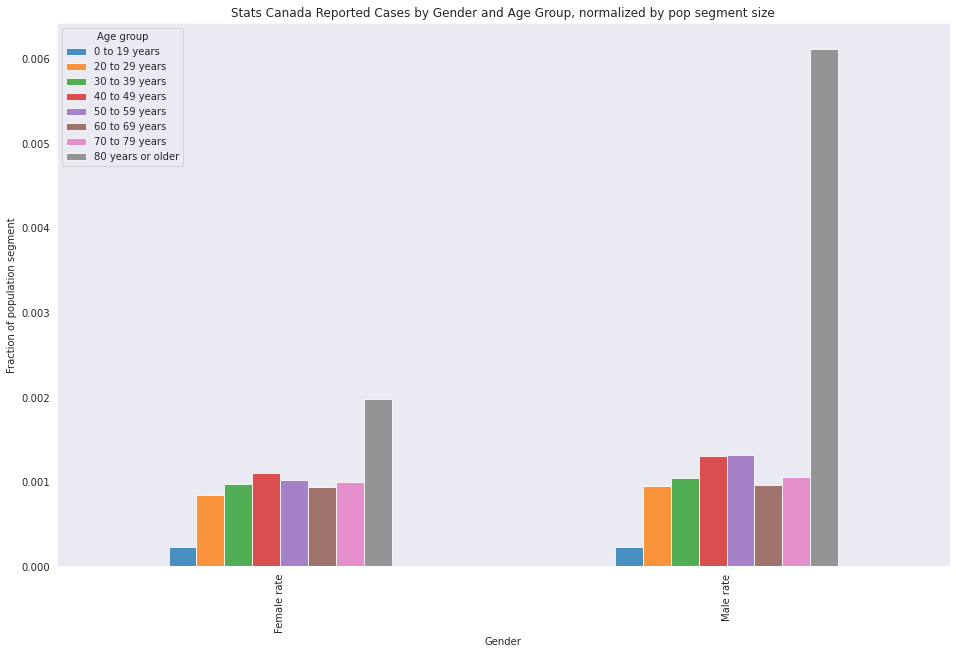

In [12]:
ax = normCaseDF.drop(['Female', 'Male'], axis=0).plot(kind='bar', alpha=0.8)
ax.set_title('Stats Canada Reported Cases by Gender and Age Group, normalized by pop segment size')
ax.set_ylabel('Fraction of population segment')

In [13]:
normDeathDF = deathDF.drop('Not stated', axis=1).drop('Not stated')
normDeathDF

Age group,20 to 29 years,30 to 39 years,40 to 49 years,50 to 59 years,60 to 69 years,70 to 79 years,80 years or older
Gender,,,,,,,
Female,3.0,NaN,6.0,27.0,72.0,146.0,905.0
Male,2.0,8.0,12.0,42.0,115.0,254.0,618.0


In [14]:
normDeathDF.loc['Female rate'] = normDeathDF.loc['Female'] / popDF2.loc['Females']
normDeathDF.loc['Male rate']   = normDeathDF.loc['Male'] / popDF2.loc['Males']
normDeathDF

Age group,20 to 29 years,30 to 39 years,40 to 49 years,50 to 59 years,60 to 69 years,70 to 79 years,80 years or older
Gender,,,,,,,
Female,3.000000e+00,NaN,6.000000,27.000000,72.000000,146.000000,905.000000
Male,2.000000e+00,8.000000,12.000000,42.000000,115.000000,254.000000,618.000000
Female rate,1.221993e-06,NaN,0.000002,0.000010,0.000031,0.000097,0.000931
Male rate,7.555250e-07,0.000003,0.000005,0.000016,0.000051,0.000187,0.000947


Text(0, 0.5, 'Fraction of population segment')

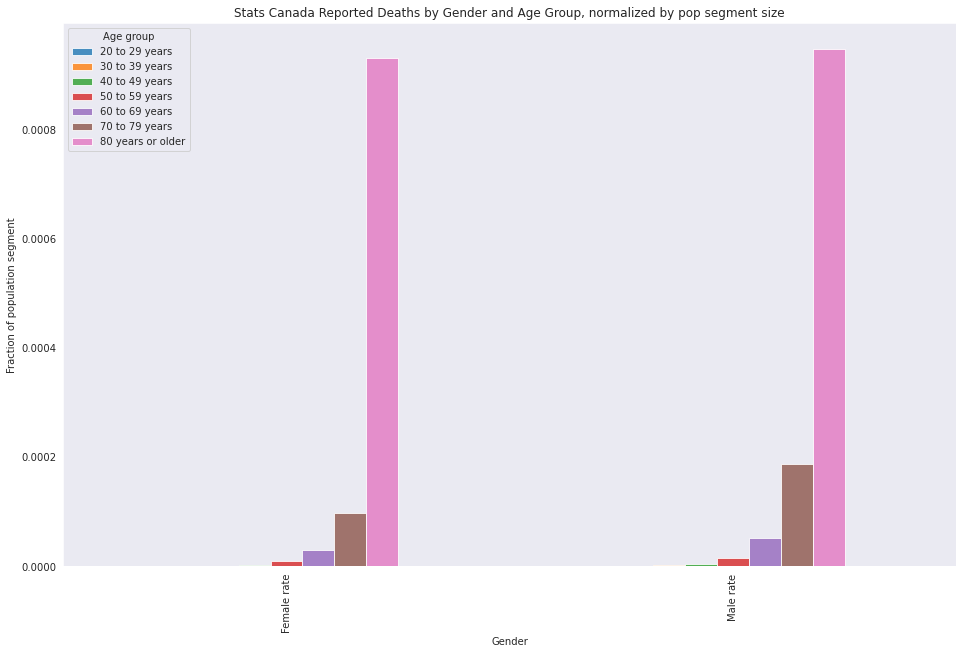

In [15]:
ax = normDeathDF.drop(['Female', 'Male'], axis=0).plot(kind='bar', alpha=0.8)
ax.set_title('Stats Canada Reported Deaths by Gender and Age Group, normalized by pop segment size')
ax.set_ylabel('Fraction of population segment')

So after adjusting for the population segment size the mortality rate for women makes a large jump in the 80 and over category.